In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras import layers,Model,regularizers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
batch = 16
data_dir = "/kaggle/input/indian-food-classification/Food Classification"

In [5]:
labels = ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']

In [6]:
def create_augmentation_pipeline():
    return tf.keras.Sequential([
        layers.RandomRotation(0.2),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ])

In [7]:
def prepare_dataset(data_dir, batch_size=16):
    data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=(224, 224),
        seed=42,
        shuffle=True
    )
    
    augmentation = create_augmentation_pipeline()
    
    def prepare_data(x, y):
        x = augmentation(x, training=True)
        x = tf.cast(x, tf.float32) / 255.0
        return x, y
    
    train_data = data.take(train_size).map(
        prepare_data,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)
    
    # No augmentation for validation/test data
    def normalize_only(x, y):
        return tf.cast(x, tf.float32) / 255.0, y
    
    val_data = data.skip(train_size).take(val_size).map(
        normalize_only,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)
    
    return train_data, val_data

In [8]:
train_size = int(6272*0.75/16)
val_size = int(6272*0.16/16)
test_size = int(6272*0.9/16)

In [9]:
print(train_size*batch,val_size*batch,test_size*batch)

4704 992 5632


In [10]:
train_data,val_data = prepare_dataset(data_dir)

Found 6269 files belonging to 20 classes.


In [11]:
train_iterator = train_data.as_numpy_iterator().next()
train_iterator[0].max()

1.0

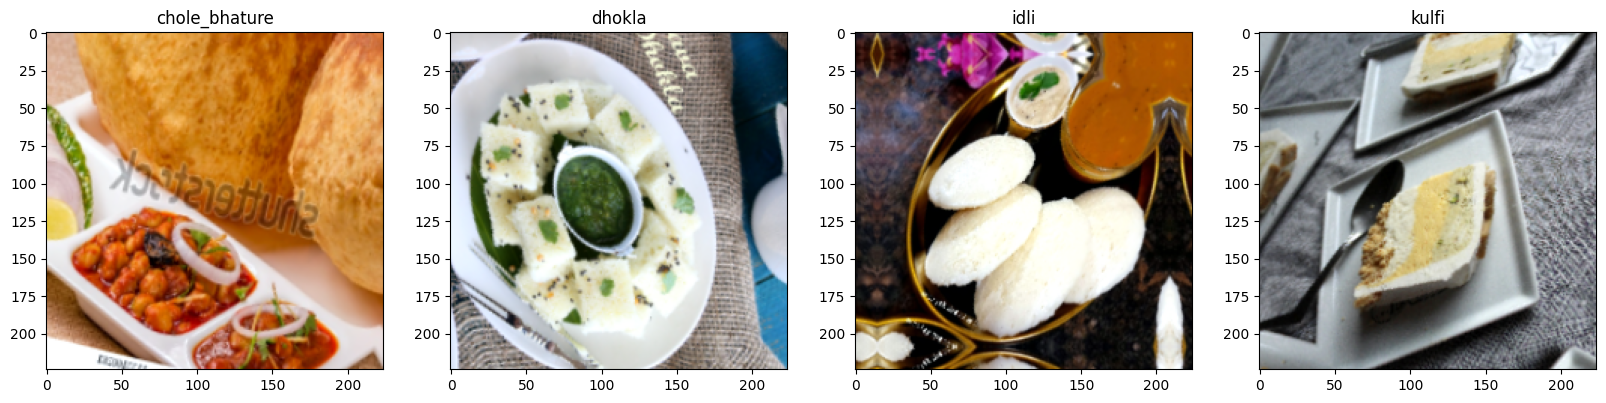

In [12]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(train_iterator[0][:4]):
    ax[idx].imshow(img.astype(float))
    index = train_iterator[1][idx]
    ax[idx].title.set_text(labels[index])

In [13]:
class SiLU(layers.Layer):
    """Custom SiLU/Swish activation layer"""
    def __init__(self, **kwargs):
        super(SiLU, self).__init__(**kwargs)
        
    def call(self, inputs):
        return inputs * tf.sigmoid(inputs)

class CoordAtt(layers.Layer):
    """Coordinate Attention module"""
    def __init__(self, reduction_ratio=32, **kwargs):
        super(CoordAtt, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.reduced_channels = max(8, channels // self.reduction_ratio)
        
        self.h_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=2))
        self.w_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))
        
        self.embedding1 = layers.Dense(
            self.reduced_channels,
            activation='relu',
            kernel_initializer='he_normal'
        )
        
        self.h_embedding2 = layers.Dense(channels, kernel_initializer='he_normal')
        self.w_embedding2 = layers.Dense(channels, kernel_initializer='he_normal')
        
        self.multiply = layers.Multiply()
        self.activation = layers.Activation('sigmoid')

    def call(self, inputs):
        h_att = self.h_pool(inputs)
        w_att = self.w_pool(inputs)
        
        h_att = self.embedding1(h_att)
        w_att = self.embedding1(w_att)
        
        h_att = self.h_embedding2(h_att)
        w_att = self.w_embedding2(w_att)
        
        h_att = tf.expand_dims(h_att, axis=2)
        w_att = tf.expand_dims(w_att, axis=1)
        
        att = self.activation(self.multiply([h_att, w_att]))
        
        return self.multiply([inputs, att])

class ImprovedDualPathBlock(layers.Layer):
    """Enhanced Dual Path Block with attention mechanisms"""
    def __init__(self, dense_channels, residual_channels, proj_channels, 
                 groups=32, stride=1, use_coord_att=True, **kwargs): #dropout_rate=0.2,
        super(ImprovedDualPathBlock, self).__init__(**kwargs)
        self.dense_channels = dense_channels
        self.residual_channels = residual_channels
        self.proj_channels = proj_channels
        self.groups = groups
        self.stride = stride
        self.use_coord_att = use_coord_att
        #self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(
            self.proj_channels, 1, padding='same', use_bias=False,
            kernel_initializer='he_normal',
            kernel_regularizer=regularizers.l2(1e-3)
        )
        self.bn1 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        self.act1 = SiLU()
        
        self.conv2 = layers.Conv2D(
            self.proj_channels, 3, strides=self.stride, padding='same',
            groups=self.groups, use_bias=False,
            kernel_initializer='he_normal',
            kernel_regularizer=regularizers.l2(1e-3)
        )
        self.bn2 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        self.act2 = SiLU()
        
        self.conv3 = layers.Conv2D(
            self.dense_channels + self.residual_channels, 1, padding='same',
            use_bias=False,
            kernel_initializer='he_normal',
            kernel_regularizer=regularizers.l2(1e-3)
        )
        self.bn3 = layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
        self.act3 = SiLU()
        
        if self.use_coord_att:
            self.coord_att = CoordAtt(reduction_ratio=16)
        
        if self.stride > 1 or input_shape[-1] != (self.dense_channels + self.residual_channels):
            self.shortcut = layers.Conv2D(
                self.dense_channels + self.residual_channels, 1,
                strides=self.stride, padding='same', use_bias=False,
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(1e-3)
            )
        else:
            self.shortcut = None
            
        self.concat = layers.Concatenate(axis=-1)
        
        self.add = layers.Add()

        # Adding dropout layers
        #self.dropout1 = layers.Dropout(self.dropout_rate)
        #self.dropout2 = layers.Dropout(self.dropout_rate)
        #self.dropout3 = layers.Dropout(self.dropout_rate)

    def call(self, inputs, training=None):
        shortcut = inputs
        
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        #x = self.dropout1(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        #x = self.dropout2(x, training=training)

        if self.use_coord_att:
            x = self.coord_att(x)
        
        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)
        #x = self.dropout3(x, training=training)
        
        if self.shortcut is not None:
            shortcut = self.shortcut(shortcut)
        
        if shortcut is not None:
            x = layers.Add()([x, shortcut])
        
        dense_features = x[:, :, :, :self.dense_channels]
        residual_features = x[:, :, :, self.dense_channels:]
        
        return self.concat([dense_features, residual_features])

def ImprovedDPN92(input_shape=(224, 224, 3), num_classes=20, include_top=True):
    """Enhanced DPN92 with modern architectural improvements"""

    # Stage configurations
    stages_config = [
        # dense_ch, res_ch, proj_ch, blocks, stride, coord_att
        (256, 16, 96, 3, 1, True),
        (512, 32, 192, 4, 2, True),
        (1024, 24, 384, 20, 2, True),
        (2048, 128, 768, 3, 2, True),
    ]
    
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Initial conv layers with dropout
    x = layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False,
                     kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    #x = layers.Dropout(0.2)(x)
    
    # Stem block with early feature mixing
    x = layers.Conv2D(64, 3, padding='same', use_bias=False,
                     kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = SiLU()(x)
    #x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(64, 3, padding='same', use_bias=False,
                     kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = SiLU()(x)
    #x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(128, 3, padding='same', use_bias=False,
                     kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = SiLU()(x)
    x = layers.MaxPool2D(3, strides=2, padding='same')(x)
    #x = layers.Dropout(0.2)(x)
    
    # Main network stages
    for i, (d_ch, r_ch, p_ch, blocks, stride, use_att) in enumerate(stages_config):
        for b in range(blocks):
            x = ImprovedDualPathBlock(
                dense_channels=d_ch,
                residual_channels=r_ch,
                proj_channels=p_ch,
                stride=stride if b == 0 else 1,
                use_coord_att=use_att,
                #dropout_rate=0.2
            )(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Dropout(0.5)(x)
    
    if include_top:
        x = layers.Dense(
            num_classes,
            activation='softmax',
            kernel_regularizer=regularizers.l2(1e-4)
        )(x)
    
    return Model(inputs=inputs, outputs=x, name='improved_dpn92')

In [14]:
model = ImprovedDPN92(input_shape=(224, 224, 3), num_classes=20)

In [15]:
epochs = 100
batch = 16
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [16]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=epochs * ((train_size*16)//16),
    alpha=1e-5  # Final learning rate as a fraction of initial
)

optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Set the weight decay using the `clipvalue` or `clipnorm` if required elsewhere.
optim.weight_decay = 1e-3

In [17]:
'''optim = tf.keras.optimizers.SGD(momentum=0.9,nesterov=True,learning_rate=0.0001)'''

'optim = tf.keras.optimizers.SGD(momentum=0.9,nesterov=True,learning_rate=0.0001)'

In [18]:
model.compile(optimizer=optim,loss=loss,metrics=['accuracy'])

In [19]:
model.summary()

Model: "improved_dpn92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ si_lu (SiLU)                    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ si_lu_1 (SiLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ si_lu_2 (SiLU)                  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_dual_path_block        │ (None, 56, 56, 272)    │        80,168 │
│ (ImprovedDualPathBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_dual_path_block_1      │ (None, 56, 56, 272)    │        59,176 │
│ (ImprovedDualPathBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_dual_path_block_2      │ (None, 56, 56, 272)    │        59,176 │
│ (ImprovedDualPathBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_dual_path_block_3      │ (None, 28, 28, 544)    │       326,028 │
│ (ImprovedDualPathBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_dual_path_block_4      │ (None, 28, 28, 544)    │       230,284 │
│ (ImprovedDualPathBlock)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_dual_path_block_5      │ (None, 28, 28, 544)    │       230,284 │
│ (ImprovedDualPathBlock)         │                        │             

 Total params: 31,727,244 (121.03 MB)

 Trainable params: 31,621,548 (120.63 MB)

 Non-trainable params: 105,696 (412.88 KB)

In [20]:
history = model.fit(train_data,validation_data=val_data,epochs=epochs)

Epoch 1/100


I0000 00:00:1731901042.871231      70 service.cc:145] XLA service 0x7a57780020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731901042.871296      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731901134.921070      70 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_181', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_102', 40 bytes spill stores, 80 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1731901135.034247      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


294/294 ━━━━━━━━━━━━━━━━━━━━ 301s 392ms/step - accuracy: 0.1016 - loss: 117.8373 - val_accuracy: 0.1129 - val_loss: 58.0368
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 106s 360ms/step - accuracy: 0.1604 - loss: 50.6535 - val_accuracy: 0.1522 - val_loss: 33.4351
Epoch 3/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 106s 359ms/step - accuracy: 0.1469 - loss: 29.9737 - val_accuracy: 0.1300 - val_loss: 22.4230
Epoch 4/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 106s 359ms/step - accuracy: 0.1625 - loss: 20.4592 - val_accuracy: 0.1754 - val_loss: 17.9751
Epoch 5/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 106s 359ms/step - accuracy: 0.1982 - loss: 15.5081 - val_accuracy: 0.2046 - val_loss: 13.5031
Epoch 6/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 106s 359ms/step - accuracy: 0.2211 - loss: 12.5518 - val_accuracy: 0.2117 - val_loss: 23.4224
Epoch 7/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 106s 359ms/step - accuracy: 0.2574 - loss: 10.3552 - val_accuracy: 0.2500 - val_loss: 9.1986
Epoch 8/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 106s 358ms/step - accuracy

In [21]:
model.save("/kaggle/working/improvedmodel0.keras")

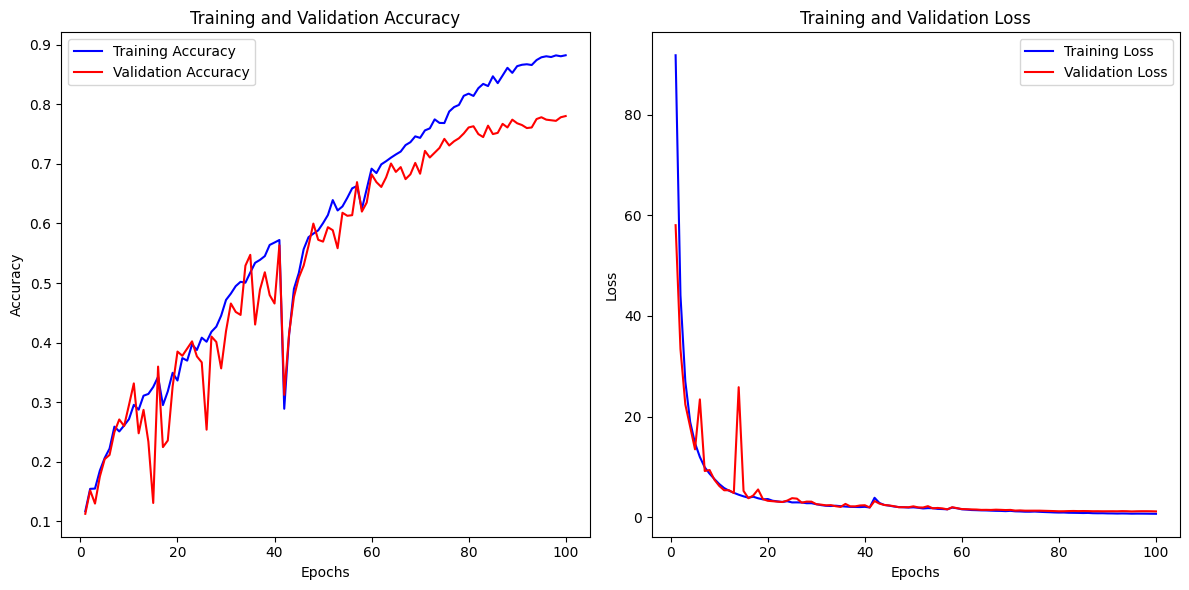

In [22]:
# Extract data from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
data_test = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        batch_size=16,
        image_size=(224, 224),
    )


Found 6269 files belonging to 20 classes.


In [24]:
class_names = ['momos',
 'dhokla',
 'kaathi_rolls',
 'chole_bhature',
 'masala_dosa',
 'dal_makhani',
 'burger',
 'chai',
 'chapati',
 'paani_puri',
 'pav_bhaji',
 'pakode',
 'idli',
 'jalebi',
 'kadai_paneer',
 'samosa',
 'butter_naan',
 'pizza',
 'kulfi',
 'fried_rice']

class_names.sort()

In [25]:
test_data = data_test.skip(train_size).skip(val_size//3).take(val_size+test_size)

In [26]:
test_data = test_data.map(lambda x,y : (x/255,y))

In [27]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 202ms/step - accuracy: 0.9076 - loss: 0.7304


In [28]:
# Print the test results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.7031347155570984
Test Accuracy: 0.9052208662033081


In [29]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(len(class_names)))
accuracy = np.mean(y_true == y_pred)

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━

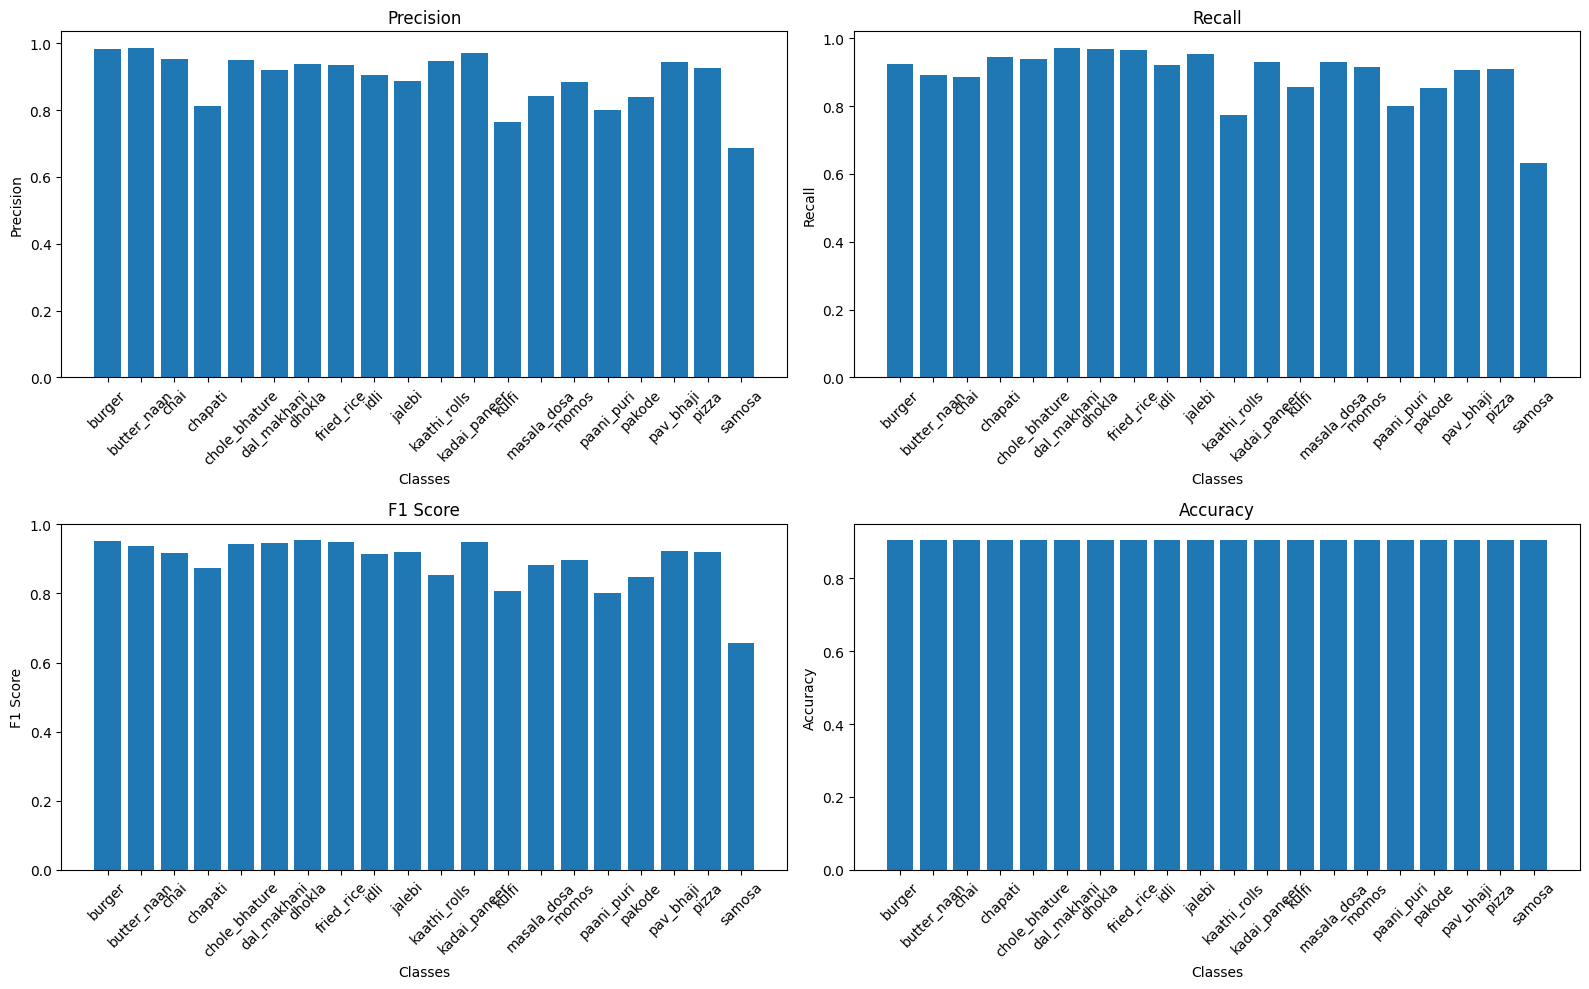

In [30]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Plot metrics
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
values = [precision, recall, f1_score, [accuracy] * len(class_names)]

plt.figure(figsize=(16, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(range(len(class_names)), values[i], tick_label=class_names)
    plt.title(metric)
    plt.xlabel('Classes')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()

# Show plots
plt.show()

<Figure size 1500x1500 with 0 Axes>

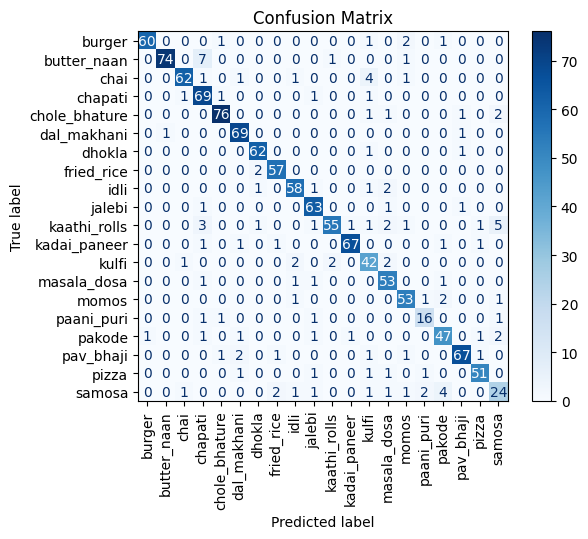

In [31]:
# Plot confusion matrix
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=90, values_format='d')
plt.title("Confusion Matrix")
plt.show()